### Abstract
We present pure-transformer based models for video classification, drawing upon the recent success of such models in image classification. Our model extracts spatio-temporal tokens from the input video, which are then encoded by a series of transformer layers. In order to handle the long sequences of tokens encountered in video, we propose several, efficient variants of our model which factorise the spatial- and temporal-dimensions of the input. Although transformer-based models are known to only be effective when large training datasets are available, we show how we can effectively regularise the model during training and leverage pretrained image models to be able to train on comparatively small datasets. We conduct thorough ablation studies, and achieve state-of-the-art results on multiple video classification benchmarks including Kinetics 400 and 600, Epic Kitchens, Something-Something v2 and Moments in Time, outperforming prior methods based on deep 3D convolutional networks. To facilitate further research, we release code at https://github.com/google-research/scenic/tree/main/scenic/projects/vivit

https://arxiv.org/pdf/2103.15691



## Embeddings
### Uniform frame sampling 
straightforward method of tokenising the input video is to uniformly sample nt frames from the input video clip, embed each 2D frame independently using the same method as ViT, and concatenate all these tokens together. Concretely, if nh · nw non-overlapping image patches are extracted from each frame, then a total of nt ·nh·nw tokens will be forwarded through the transformer encoder.Intuitively, this process may be seen as simply constructing a large 2D image to be tokenised following ViT

#### Tubelet embedding
An alternate method, to extract non-overlapping, spatio-temporal “tubes” from the input volume, and to linearly project this to Rd. This method is an extension of ViT’s embedding to 3D,and corresponds to a 3D convolution. 

### HF Vivit
https://huggingface.co/docs/transformers/main/model_doc/vivit


In [1]:
from transformers import TrainingArguments
from transformers import Trainer, TrainingArguments, AdamW
from transformers import Trainer
import wandb
import os
import numpy as np
import av
from pathlib import Path
import torch
from transformers import VivitImageProcessor
from datasets import Dataset
from transformers import  VivitConfig,VivitForVideoClassification
import evaluate
import pyarrow as pa


c:\Users\rajen\Downloads\project\final\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Base Model

https://github.com/google-research/scenic/tree/main/scenic/projects/vivit

### google/vivit-f-16x2-kinetics400


##### https://huggingface.co/docs/transformers/main/model_doc/vivit

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def generate_all_files(root: Path, only_files: bool = True):
    for p in root.rglob("*"):
        if only_files and not p.is_file():
            continue
        yield p

In [4]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            reformatted_frame = frame.reformat(width=224,height=224)
            frames.append(reformatted_frame)
    new=np.stack([x.to_ndarray(format="rgb24") for x in frames])

    return new

In [5]:
def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [3]:
def frames_convert_and_create_dataset_dictionary(directory):
    class_labels = []
    all_videos=[]
    video_files= []
    sizes = []
    for p in generate_all_files(Path(directory), only_files=True):
        set_files = "" # train or test
        cls = str(p).split("\\")[1] # class
        file= str(p).split("\\")[2] # file name
        #file name path
        file_name= os.path.join(directory, set_files, cls, file)
        # print(f"Processing file {file_name}")    
        # Process class
        if cls not in class_labels:
            class_labels.append(cls)
        # process video File
        container = av.open(file_name)
        print(f"Processing file {file_name} number of Frames: {container.streams.video[0].frames}")  
        indices = sample_frame_indices(clip_len=10, frame_sample_rate=1,seg_len=container.streams.video[0].frames)
        video = read_video_pyav(container=container, indices=indices)
        all_videos.append({'video': video, 'labels': cls})
        sizes.append(container.streams.video[0].frames)
    sizes = np.array(sizes)
    print(f"Min number frames {sizes.min()}")
    return all_videos, class_labels

In [10]:
path_files = "dataset"
video_dict, class_labels = frames_convert_and_create_dataset_dictionary(path_files)


Processing file dataset\test\Anomaly\Abuse003_x264.mp4 number of Frames: 3699
Processing file dataset\test\Anomaly\Abuse012_x264.mp4 number of Frames: 5130
Processing file dataset\test\Anomaly\Abuse019_x264.mp4 number of Frames: 3943
Processing file dataset\test\Anomaly\Abuse020_x264.mp4 number of Frames: 3104
Processing file dataset\test\Anomaly\Abuse027_x264.mp4 number of Frames: 4372
Processing file dataset\test\Anomaly\Abuse031_x264.mp4 number of Frames: 4442
Processing file dataset\test\Anomaly\Abuse033_x264.mp4 number of Frames: 2831
Processing file dataset\test\Anomaly\Abuse035_x264.mp4 number of Frames: 2651
Processing file dataset\test\Anomaly\Abuse043_x264.mp4 number of Frames: 3870
Processing file dataset\test\Anomaly\Abuse044_x264.mp4 number of Frames: 3940
Processing file dataset\test\Anomaly\Abuse045_x264.mp4 number of Frames: 5085
Processing file dataset\test\Anomaly\Abuse048_x264.mp4 number of Frames: 3416
Processing file dataset\test\Anomaly\Assault001_x264.mp4 number 

In [11]:
len(video_dict)

335

In [12]:
video_dict[0].keys()

dict_keys(['video', 'labels'])

In [13]:
video_dict[0]['video'].shape

(10, 224, 224, 3)

In [14]:
video_dict[0]['labels']

'Anomaly'

In [15]:
video_dict

[{'video': array([[[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
  
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
  
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
  
          ...,
  
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
  
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
  
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]]],
  
  
         [[[0, 0, 0],
           [0, 0, 0],
           [0

In [16]:
num_frames, height, width, channels =  video_dict[0]['video'].shape
num_frames, height, width, channels 

(10, 224, 224, 3)

# Display Video sample

In [17]:
# filename = "./tmp/saved.mp4"
# codec_id = "mp4v" # ID for a video codec.
# fourcc = cv2.VideoWriter_fourcc(*codec_id)
# out = cv2.VideoWriter(filename, fourcc=fourcc, fps=2, frameSize=(width, height))

# for frame in np.split(video_dict[0]['video'], num_frames, axis=0):
#     out.write(frame)

In [18]:
# container2 = av.open("./tmp/saved.mp4")
# moviepy.editor.ipython_display(container2.name)

In [19]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")


In [20]:
def process_example(example):
    inputs = image_processor(list(np.array(example['video'])), return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [67]:
def create_dataset(video_dictionary):
    dataset = Dataset.from_list(video_dictionary)
    dataset = dataset.class_encode_column("labels")
    processed_dataset = dataset.map(process_example, batched=False)
    processed_dataset=processed_dataset.remove_columns(['video'])
    # shuffled_dataset= processed_dataset.shuffle(seed=42)
    # shuffled_dataset= shuffled_dataset.map(lambda x: {'pixel_values': torch.tensor(x['pixel_values']).squeeze()})
    # shuffled_dataset =shuffled_dataset.train_test_split(test_size=0.1)
    return processed_dataset

In [22]:
class_labels = sorted(class_labels)
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['Anomaly', 'Normal'].


In [23]:
shuffled_dataset = create_dataset(video_dict)

Map: 100%|██████████| 335/335 [10:39<00:00,  1.91s/ examples]


In [24]:
shuffled_dataset['train'].features

{'labels': ClassLabel(names=['Anomaly', 'Normal'], id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None)}

In [25]:
metric = evaluate.load("accuracy", trust_remote_code=True)


In [26]:
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [27]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([(torch.tensor(x['pixel_values']))  for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])}


In [38]:
def initialise_model(shuffled_dataset, device="cpu", model="google/vivit-b-16x2-kinetics400"):
    labels = shuffled_dataset['train'].features['labels'].names
    config = VivitConfig.from_pretrained(model)
    config.num_classes = len(labels)
    config.id2label = {str(i): c for i, c in enumerate(labels)}
    config.label2id = {c: str(i) for i, c in enumerate(labels)}
    config.num_frames = 10 
    config.video_size = [10, 224, 224]
    
    model = VivitForVideoClassification.from_pretrained(
        model,
        ignore_mismatched_sizes=True,
        config=config,
    ).to(device)
    
    model.classifier = torch.nn.Linear(config.hidden_size, config.num_classes).to(device)
    return model


In [39]:

model = initialise_model(shuffled_dataset, device)

Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- vivit.embeddings.position_embeddings: found shape torch.Size([1, 3137, 768]) in the checkpoint and torch.Size([1, 981, 768]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
training_output_dir = "/results"
training_args = TrainingArguments(
    output_dir=training_output_dir,         
    num_train_epochs=5,             
    per_device_train_batch_size=2,   
    per_device_eval_batch_size=2,    
    learning_rate=5e-05,            
    weight_decay=0.01,              
    logging_dir="./logs",           
    logging_steps=10,                
    seed=42,                       
    eval_strategy="steps",    
    eval_steps=10,                   
    warmup_steps=int(0.1 * 20),      
    optim="adamw_torch",          
    lr_scheduler_type="linear",      
    fp16=True,  
    report_to="wandb"
)

In [44]:
wandb_key =  "eabd3fc21f419b1be01ef16800277196b691ed1b"
wandb.login(key=wandb_key)

PROJECT = "ViViT-finalversion"
MODEL_NAME = "google/vivit-b-16x2-kinetics400"
DATASET = "ucf-crime"

wandb.init(project=PROJECT, # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes ="Fine tuning ViViT with ucf-crime")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [45]:
shuffled_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 301
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 34
    })
})

In [46]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-05, betas=(0.9, 0.999), eps=1e-08)
# Define the trainer
trainer = Trainer(
    model=model,                      
    args=training_args,              
    train_dataset=shuffled_dataset["train"],      
    eval_dataset=shuffled_dataset["test"],       
    optimizers=(optimizer, None),  
    compute_metrics = compute_metrics
)

In [47]:
with wandb.init(project=PROJECT, job_type="train", # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes =f"Fine tuning {MODEL_NAME} with {DATASET}."):
           train_results = trainer.train()

c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       
  0%|          | 0/755 [04:34<?, ?it/s]           

{'loss': 0.7839, 'grad_norm': 19.477251052856445, 'learning_rate': 4.960159362549801e-05, 'epoch': 0.07}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [05:44<?, ?it/s]           



{'eval_loss': 0.8207954168319702, 'eval_accuracy': 0.47058823529411764, 'eval_runtime': 70.1, 'eval_samples_per_second': 0.485, 'eval_steps_per_second': 0.243, 'epoch': 0.07}


                                       
  0%|          | 0/755 [06:33<?, ?it/s]           

{'loss': 0.5285, 'grad_norm': 17.151691436767578, 'learning_rate': 4.893758300132802e-05, 'epoch': 0.13}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [07:43<?, ?it/s]           



{'eval_loss': 0.6681473851203918, 'eval_accuracy': 0.6470588235294118, 'eval_runtime': 69.0527, 'eval_samples_per_second': 0.492, 'eval_steps_per_second': 0.246, 'epoch': 0.13}


                                       
  0%|          | 0/755 [08:34<?, ?it/s]           

{'loss': 0.6434, 'grad_norm': 29.756900787353516, 'learning_rate': 4.827357237715804e-05, 'epoch': 0.2}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [09:42<?, ?it/s]           



{'eval_loss': 0.6698280572891235, 'eval_accuracy': 0.7352941176470589, 'eval_runtime': 68.0357, 'eval_samples_per_second': 0.5, 'eval_steps_per_second': 0.25, 'epoch': 0.2}


                                       
  0%|          | 0/755 [10:28<?, ?it/s]           

{'loss': 0.4147, 'grad_norm': 2.890148639678955, 'learning_rate': 4.760956175298805e-05, 'epoch': 0.26}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [11:36<?, ?it/s]           



{'eval_loss': 0.3197680711746216, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 68.479, 'eval_samples_per_second': 0.497, 'eval_steps_per_second': 0.248, 'epoch': 0.26}


                                       
  0%|          | 0/755 [12:23<?, ?it/s]           

{'loss': 0.7088, 'grad_norm': 30.653823852539062, 'learning_rate': 4.6945551128818064e-05, 'epoch': 0.33}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [13:32<?, ?it/s]           



{'eval_loss': 0.7949708104133606, 'eval_accuracy': 0.6764705882352942, 'eval_runtime': 68.8906, 'eval_samples_per_second': 0.494, 'eval_steps_per_second': 0.247, 'epoch': 0.33}


                                       
  0%|          | 0/755 [14:18<?, ?it/s]           

{'loss': 0.9681, 'grad_norm': 105.1075439453125, 'learning_rate': 4.628154050464807e-05, 'epoch': 0.4}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [15:27<?, ?it/s]           



{'eval_loss': 2.7031784057617188, 'eval_accuracy': 0.4117647058823529, 'eval_runtime': 69.0844, 'eval_samples_per_second': 0.492, 'eval_steps_per_second': 0.246, 'epoch': 0.4}


                                       
  0%|          | 0/755 [16:15<?, ?it/s]           

{'loss': 1.245, 'grad_norm': 42.15038299560547, 'learning_rate': 4.561752988047809e-05, 'epoch': 0.46}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [17:25<?, ?it/s]           



{'eval_loss': 0.733131468296051, 'eval_accuracy': 0.6764705882352942, 'eval_runtime': 69.3715, 'eval_samples_per_second': 0.49, 'eval_steps_per_second': 0.245, 'epoch': 0.46}


                                       
  0%|          | 0/755 [18:12<?, ?it/s]           

{'loss': 1.1099, 'grad_norm': 25.634315490722656, 'learning_rate': 4.4953519256308105e-05, 'epoch': 0.53}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [19:21<?, ?it/s]           



{'eval_loss': 1.7198814153671265, 'eval_accuracy': 0.35294117647058826, 'eval_runtime': 68.8565, 'eval_samples_per_second': 0.494, 'eval_steps_per_second': 0.247, 'epoch': 0.53}


                                       
  0%|          | 0/755 [20:07<?, ?it/s]           

{'loss': 1.4482, 'grad_norm': 20.526323318481445, 'learning_rate': 4.428950863213812e-05, 'epoch': 0.6}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [21:18<?, ?it/s]           



{'eval_loss': 1.1589670181274414, 'eval_accuracy': 0.47058823529411764, 'eval_runtime': 71.2325, 'eval_samples_per_second': 0.477, 'eval_steps_per_second': 0.239, 'epoch': 0.6}


                                       
  0%|          | 0/755 [22:07<?, ?it/s]            

{'loss': 0.8936, 'grad_norm': 12.557337760925293, 'learning_rate': 4.362549800796813e-05, 'epoch': 0.66}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [23:18<?, ?it/s]            



{'eval_loss': 0.5041710138320923, 'eval_accuracy': 0.7941176470588235, 'eval_runtime': 71.2869, 'eval_samples_per_second': 0.477, 'eval_steps_per_second': 0.238, 'epoch': 0.66}


                                       
  0%|          | 0/755 [24:06<?, ?it/s]            

{'loss': 0.6133, 'grad_norm': 8.290149688720703, 'learning_rate': 4.2961487383798146e-05, 'epoch': 0.73}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [25:12<?, ?it/s]            



{'eval_loss': 0.7027983069419861, 'eval_accuracy': 0.6176470588235294, 'eval_runtime': 65.9374, 'eval_samples_per_second': 0.516, 'eval_steps_per_second': 0.258, 'epoch': 0.73}


                                       
  0%|          | 0/755 [25:53<?, ?it/s]          

{'loss': 0.6472, 'grad_norm': 24.280136108398438, 'learning_rate': 4.229747675962816e-05, 'epoch': 0.79}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [26:58<?, ?it/s]          



{'eval_loss': 1.2249685525894165, 'eval_accuracy': 0.6764705882352942, 'eval_runtime': 65.0408, 'eval_samples_per_second': 0.523, 'eval_steps_per_second': 0.261, 'epoch': 0.79}


                                       
  0%|          | 0/755 [27:45<?, ?it/s]          

{'loss': 0.8896, 'grad_norm': 40.130611419677734, 'learning_rate': 4.1633466135458174e-05, 'epoch': 0.86}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [28:54<?, ?it/s]          



{'eval_loss': 1.358311653137207, 'eval_accuracy': 0.6470588235294118, 'eval_runtime': 68.8109, 'eval_samples_per_second': 0.494, 'eval_steps_per_second': 0.247, 'epoch': 0.86}


                                       
  0%|          | 0/755 [29:40<?, ?it/s]          

{'loss': 1.2217, 'grad_norm': 5.521273136138916, 'learning_rate': 4.096945551128819e-05, 'epoch': 0.93}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [30:49<?, ?it/s]          



{'eval_loss': 1.062248706817627, 'eval_accuracy': 0.35294117647058826, 'eval_runtime': 68.6213, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.248, 'epoch': 0.93}


                                       
  0%|          | 0/755 [31:35<?, ?it/s]          

{'loss': 1.0373, 'grad_norm': 10.619630813598633, 'learning_rate': 4.0305444887118194e-05, 'epoch': 0.99}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [32:45<?, ?it/s]          



{'eval_loss': 0.639549732208252, 'eval_accuracy': 0.6470588235294118, 'eval_runtime': 70.7752, 'eval_samples_per_second': 0.48, 'eval_steps_per_second': 0.24, 'epoch': 0.99}


                                       
  0%|          | 0/755 [33:43<?, ?it/s]            

{'loss': 1.0023, 'grad_norm': 11.473196029663086, 'learning_rate': 3.964143426294821e-05, 'epoch': 1.06}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [34:58<?, ?it/s]            



{'eval_loss': 0.5659969449043274, 'eval_accuracy': 0.6764705882352942, 'eval_runtime': 74.1678, 'eval_samples_per_second': 0.458, 'eval_steps_per_second': 0.229, 'epoch': 1.06}


                                       
  0%|          | 0/755 [35:48<?, ?it/s]          

{'loss': 0.5982, 'grad_norm': 5.255067348480225, 'learning_rate': 3.897742363877822e-05, 'epoch': 1.13}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [37:07<?, ?it/s]          



{'eval_loss': 0.571967601776123, 'eval_accuracy': 0.7352941176470589, 'eval_runtime': 78.801, 'eval_samples_per_second': 0.431, 'eval_steps_per_second': 0.216, 'epoch': 1.13}


                                       
  0%|          | 0/755 [37:54<?, ?it/s]          

{'loss': 0.4181, 'grad_norm': 7.646589279174805, 'learning_rate': 3.8313413014608236e-05, 'epoch': 1.19}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [39:03<?, ?it/s]          



{'eval_loss': 0.4828791916370392, 'eval_accuracy': 0.7058823529411765, 'eval_runtime': 68.8646, 'eval_samples_per_second': 0.494, 'eval_steps_per_second': 0.247, 'epoch': 1.19}


                                       
  0%|          | 0/755 [39:49<?, ?it/s]          

{'loss': 0.7302, 'grad_norm': 22.25094223022461, 'learning_rate': 3.764940239043825e-05, 'epoch': 1.26}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [40:57<?, ?it/s]          



{'eval_loss': 0.7950210571289062, 'eval_accuracy': 0.7058823529411765, 'eval_runtime': 68.0178, 'eval_samples_per_second': 0.5, 'eval_steps_per_second': 0.25, 'epoch': 1.26}


                                       
  0%|          | 0/755 [41:43<?, ?it/s]          

{'loss': 0.3404, 'grad_norm': 1.1604180335998535, 'learning_rate': 3.698539176626826e-05, 'epoch': 1.32}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [42:50<?, ?it/s]          



{'eval_loss': 0.6299986839294434, 'eval_accuracy': 0.6764705882352942, 'eval_runtime': 67.4722, 'eval_samples_per_second': 0.504, 'eval_steps_per_second': 0.252, 'epoch': 1.32}


                                       
  0%|          | 0/755 [43:36<?, ?it/s]          

{'loss': 0.5941, 'grad_norm': 65.21678924560547, 'learning_rate': 3.632138114209828e-05, 'epoch': 1.39}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [44:43<?, ?it/s]          



{'eval_loss': 0.5083866119384766, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 67.0914, 'eval_samples_per_second': 0.507, 'eval_steps_per_second': 0.253, 'epoch': 1.39}


                                       
  0%|          | 0/755 [45:31<?, ?it/s]          

{'loss': 1.1536, 'grad_norm': 31.063995361328125, 'learning_rate': 3.565737051792829e-05, 'epoch': 1.46}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [46:39<?, ?it/s]          



{'eval_loss': 0.80840003490448, 'eval_accuracy': 0.6764705882352942, 'eval_runtime': 68.1653, 'eval_samples_per_second': 0.499, 'eval_steps_per_second': 0.249, 'epoch': 1.46}


                                       
  0%|          | 0/755 [47:19<?, ?it/s]          

{'loss': 0.5932, 'grad_norm': 31.321765899658203, 'learning_rate': 3.4993359893758304e-05, 'epoch': 1.52}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [48:19<?, ?it/s]          



{'eval_loss': 0.5550128817558289, 'eval_accuracy': 0.7647058823529411, 'eval_runtime': 59.9278, 'eval_samples_per_second': 0.567, 'eval_steps_per_second': 0.284, 'epoch': 1.52}


                                       
  0%|          | 0/755 [49:00<?, ?it/s]          

{'loss': 0.5661, 'grad_norm': 1.5275694131851196, 'learning_rate': 3.432934926958831e-05, 'epoch': 1.59}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [49:58<?, ?it/s]          



{'eval_loss': 0.5525849461555481, 'eval_accuracy': 0.7647058823529411, 'eval_runtime': 57.9727, 'eval_samples_per_second': 0.586, 'eval_steps_per_second': 0.293, 'epoch': 1.59}


                                       
  0%|          | 0/755 [50:40<?, ?it/s]          

{'loss': 0.3414, 'grad_norm': 70.18895721435547, 'learning_rate': 3.3665338645418325e-05, 'epoch': 1.66}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [51:49<?, ?it/s]          



{'eval_loss': 0.44553568959236145, 'eval_accuracy': 0.9117647058823529, 'eval_runtime': 68.2262, 'eval_samples_per_second': 0.498, 'eval_steps_per_second': 0.249, 'epoch': 1.66}


                                       
  0%|          | 0/755 [52:37<?, ?it/s]          

{'loss': 1.1225, 'grad_norm': 30.596759796142578, 'learning_rate': 3.300132802124834e-05, 'epoch': 1.72}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [53:44<?, ?it/s]          



{'eval_loss': 0.9714754819869995, 'eval_accuracy': 0.7647058823529411, 'eval_runtime': 67.0258, 'eval_samples_per_second': 0.507, 'eval_steps_per_second': 0.254, 'epoch': 1.72}


                                       
  0%|          | 0/755 [54:30<?, ?it/s]          

{'loss': 0.6445, 'grad_norm': 0.02043359912931919, 'learning_rate': 3.233731739707835e-05, 'epoch': 1.79}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [55:38<?, ?it/s]          



{'eval_loss': 0.9307383298873901, 'eval_accuracy': 0.6764705882352942, 'eval_runtime': 67.3302, 'eval_samples_per_second': 0.505, 'eval_steps_per_second': 0.252, 'epoch': 1.79}


                                       
  0%|          | 0/755 [56:24<?, ?it/s]          

{'loss': 1.6162, 'grad_norm': 6.383726119995117, 'learning_rate': 3.1673306772908366e-05, 'epoch': 1.85}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [57:31<?, ?it/s]          



{'eval_loss': 0.6630952954292297, 'eval_accuracy': 0.7352941176470589, 'eval_runtime': 66.6939, 'eval_samples_per_second': 0.51, 'eval_steps_per_second': 0.255, 'epoch': 1.85}


                                       
  0%|          | 0/755 [58:12<?, ?it/s]          

{'loss': 0.8727, 'grad_norm': 31.34427261352539, 'learning_rate': 3.100929614873838e-05, 'epoch': 1.92}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [59:11<?, ?it/s]          



{'eval_loss': 0.8787492513656616, 'eval_accuracy': 0.6470588235294118, 'eval_runtime': 58.4785, 'eval_samples_per_second': 0.581, 'eval_steps_per_second': 0.291, 'epoch': 1.92}


                                       
  0%|          | 0/755 [59:50<?, ?it/s]          

{'loss': 0.8496, 'grad_norm': 15.397957801818848, 'learning_rate': 3.0411686586985393e-05, 'epoch': 1.99}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                       

                                         
  0%|          | 0/755 [1:00:49<?, ?it/s]        



{'eval_loss': 0.49296557903289795, 'eval_accuracy': 0.7058823529411765, 'eval_runtime': 58.6721, 'eval_samples_per_second': 0.579, 'eval_steps_per_second': 0.29, 'epoch': 1.99}


                                         
  0%|          | 0/755 [1:01:27<?, ?it/s]        

{'loss': 0.4082, 'grad_norm': 26.477087020874023, 'learning_rate': 2.9747675962815407e-05, 'epoch': 2.05}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:02:25<?, ?it/s]        



{'eval_loss': 0.42279744148254395, 'eval_accuracy': 0.7941176470588235, 'eval_runtime': 58.0778, 'eval_samples_per_second': 0.585, 'eval_steps_per_second': 0.293, 'epoch': 2.05}


                                         
  0%|          | 0/755 [1:03:05<?, ?it/s]        

{'loss': 0.2948, 'grad_norm': 0.07240337133407593, 'learning_rate': 2.908366533864542e-05, 'epoch': 2.12}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:04:04<?, ?it/s]        



{'eval_loss': 0.5214415192604065, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 58.3592, 'eval_samples_per_second': 0.583, 'eval_steps_per_second': 0.291, 'epoch': 2.12}


                                         
  0%|          | 0/755 [1:04:44<?, ?it/s]          

{'loss': 0.1573, 'grad_norm': 30.277095794677734, 'learning_rate': 2.8419654714475434e-05, 'epoch': 2.19}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:05:42<?, ?it/s]          



{'eval_loss': 0.7756186127662659, 'eval_accuracy': 0.7058823529411765, 'eval_runtime': 58.2719, 'eval_samples_per_second': 0.583, 'eval_steps_per_second': 0.292, 'epoch': 2.19}


                                         
  0%|          | 0/755 [1:06:23<?, ?it/s]          

{'loss': 0.2605, 'grad_norm': 0.06734830886125565, 'learning_rate': 2.7755644090305445e-05, 'epoch': 2.25}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:07:21<?, ?it/s]          



{'eval_loss': 0.842947781085968, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 58.0572, 'eval_samples_per_second': 0.586, 'eval_steps_per_second': 0.293, 'epoch': 2.25}


                                         
  0%|          | 0/755 [1:08:02<?, ?it/s]          

{'loss': 0.4519, 'grad_norm': 41.18750762939453, 'learning_rate': 2.709163346613546e-05, 'epoch': 2.32}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:09:02<?, ?it/s]          



{'eval_loss': 0.42284050583839417, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 59.4875, 'eval_samples_per_second': 0.572, 'eval_steps_per_second': 0.286, 'epoch': 2.32}


                                         
  0%|          | 0/755 [1:09:55<?, ?it/s]          

{'loss': 0.3377, 'grad_norm': 0.18955890834331512, 'learning_rate': 2.6427622841965472e-05, 'epoch': 2.38}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:10:59<?, ?it/s]          



{'eval_loss': 1.0234801769256592, 'eval_accuracy': 0.7941176470588235, 'eval_runtime': 63.7014, 'eval_samples_per_second': 0.534, 'eval_steps_per_second': 0.267, 'epoch': 2.38}


                                         
  0%|          | 0/755 [1:11:46<?, ?it/s]          

{'loss': 0.7895, 'grad_norm': 6.105789661407471, 'learning_rate': 2.5763612217795486e-05, 'epoch': 2.45}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:12:55<?, ?it/s]          



{'eval_loss': 0.7300820350646973, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 68.8998, 'eval_samples_per_second': 0.493, 'eval_steps_per_second': 0.247, 'epoch': 2.45}


                                         
  0%|          | 0/755 [1:13:43<?, ?it/s]          

{'loss': 0.2866, 'grad_norm': 6.529412746429443, 'learning_rate': 2.50996015936255e-05, 'epoch': 2.52}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:14:52<?, ?it/s]          



{'eval_loss': 0.4961355924606323, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 68.9992, 'eval_samples_per_second': 0.493, 'eval_steps_per_second': 0.246, 'epoch': 2.52}


                                         
  0%|          | 0/755 [1:15:40<?, ?it/s]          

{'loss': 0.3883, 'grad_norm': 50.18927764892578, 'learning_rate': 2.4435590969455513e-05, 'epoch': 2.58}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:16:51<?, ?it/s]          



{'eval_loss': 0.5829811096191406, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 71.4149, 'eval_samples_per_second': 0.476, 'eval_steps_per_second': 0.238, 'epoch': 2.58}


                                         
  0%|          | 0/755 [1:17:40<?, ?it/s]          

{'loss': 0.8264, 'grad_norm': 4.954436302185059, 'learning_rate': 2.3771580345285527e-05, 'epoch': 2.65}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:18:45<?, ?it/s]          



{'eval_loss': 0.5914062261581421, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 65.1231, 'eval_samples_per_second': 0.522, 'eval_steps_per_second': 0.261, 'epoch': 2.65}


                                         
  0%|          | 0/755 [1:19:28<?, ?it/s]          

{'loss': 0.4428, 'grad_norm': 6.275693416595459, 'learning_rate': 2.3107569721115537e-05, 'epoch': 2.72}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:20:36<?, ?it/s]          



{'eval_loss': 0.6372324824333191, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 68.64, 'eval_samples_per_second': 0.495, 'eval_steps_per_second': 0.248, 'epoch': 2.72}


                                         
  0%|          | 0/755 [1:21:23<?, ?it/s]          

{'loss': 0.8025, 'grad_norm': 0.09056699275970459, 'learning_rate': 2.244355909694555e-05, 'epoch': 2.78}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:22:32<?, ?it/s]          



{'eval_loss': 0.5235211849212646, 'eval_accuracy': 0.8823529411764706, 'eval_runtime': 69.8377, 'eval_samples_per_second': 0.487, 'eval_steps_per_second': 0.243, 'epoch': 2.78}


                                         
  0%|          | 0/755 [1:23:20<?, ?it/s]          

{'loss': 0.1959, 'grad_norm': 43.229759216308594, 'learning_rate': 2.1779548472775565e-05, 'epoch': 2.85}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:24:26<?, ?it/s]          



{'eval_loss': 0.4586458206176758, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 66.6531, 'eval_samples_per_second': 0.51, 'eval_steps_per_second': 0.255, 'epoch': 2.85}


                                         
  0%|          | 0/755 [1:25:12<?, ?it/s]          

{'loss': 0.2036, 'grad_norm': 1.6814340353012085, 'learning_rate': 2.111553784860558e-05, 'epoch': 2.91}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:26:20<?, ?it/s]          



{'eval_loss': 0.4930403232574463, 'eval_accuracy': 0.8823529411764706, 'eval_runtime': 67.2327, 'eval_samples_per_second': 0.506, 'eval_steps_per_second': 0.253, 'epoch': 2.91}


                                         
  0%|          | 0/755 [1:27:06<?, ?it/s]          

{'loss': 0.3408, 'grad_norm': 0.34379082918167114, 'learning_rate': 2.0451527224435592e-05, 'epoch': 2.98}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:28:14<?, ?it/s]          



{'eval_loss': 0.3973725140094757, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 67.6672, 'eval_samples_per_second': 0.502, 'eval_steps_per_second': 0.251, 'epoch': 2.98}


                                         
  0%|          | 0/755 [1:28:58<?, ?it/s]          

{'loss': 0.0343, 'grad_norm': 0.006526919547468424, 'learning_rate': 1.9787516600265606e-05, 'epoch': 3.05}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:30:07<?, ?it/s]          



{'eval_loss': 0.45934054255485535, 'eval_accuracy': 0.8823529411764706, 'eval_runtime': 69.183, 'eval_samples_per_second': 0.491, 'eval_steps_per_second': 0.246, 'epoch': 3.05}


                                         
  0%|          | 0/755 [1:30:54<?, ?it/s]          

{'loss': 0.0006, 'grad_norm': 0.03220461308956146, 'learning_rate': 1.912350597609562e-05, 'epoch': 3.11}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:32:04<?, ?it/s]          



{'eval_loss': 0.5949229001998901, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.3753, 'eval_samples_per_second': 0.483, 'eval_steps_per_second': 0.242, 'epoch': 3.11}


                                         
  0%|          | 0/755 [1:32:52<?, ?it/s]          

{'loss': 0.2627, 'grad_norm': 0.014210576191544533, 'learning_rate': 1.8459495351925633e-05, 'epoch': 3.18}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:33:58<?, ?it/s]          



{'eval_loss': 0.4527565538883209, 'eval_accuracy': 0.8823529411764706, 'eval_runtime': 65.4559, 'eval_samples_per_second': 0.519, 'eval_steps_per_second': 0.26, 'epoch': 3.18}


                                         
  0%|          | 0/755 [1:34:46<?, ?it/s]          

{'loss': 0.6128, 'grad_norm': 0.0038147009909152985, 'learning_rate': 1.7795484727755647e-05, 'epoch': 3.25}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:35:56<?, ?it/s]          



{'eval_loss': 0.6004688143730164, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 70.1228, 'eval_samples_per_second': 0.485, 'eval_steps_per_second': 0.242, 'epoch': 3.25}


                                         
  0%|          | 0/755 [1:36:44<?, ?it/s]          

{'loss': 0.0232, 'grad_norm': 0.046560995280742645, 'learning_rate': 1.7131474103585657e-05, 'epoch': 3.31}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:37:56<?, ?it/s]          



{'eval_loss': 0.4298473596572876, 'eval_accuracy': 0.9117647058823529, 'eval_runtime': 71.4162, 'eval_samples_per_second': 0.476, 'eval_steps_per_second': 0.238, 'epoch': 3.31}


c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         
  0%|          | 0/755 [1:38:46<?, ?it/s]          

{'loss': 0.0143, 'grad_norm': 0.19233424961566925, 'learning_rate': 1.646746347941567e-05, 'epoch': 3.38}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:39:55<?, ?it/s]          



{'eval_loss': 0.48850804567337036, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 69.1974, 'eval_samples_per_second': 0.491, 'eval_steps_per_second': 0.246, 'epoch': 3.38}


                                         
  0%|          | 0/755 [1:40:42<?, ?it/s]          

{'loss': 0.002, 'grad_norm': 0.013644455000758171, 'learning_rate': 1.5803452855245685e-05, 'epoch': 3.44}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:41:53<?, ?it/s]          



{'eval_loss': 0.5138620138168335, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.5855, 'eval_samples_per_second': 0.482, 'eval_steps_per_second': 0.241, 'epoch': 3.44}


                                         
  0%|          | 0/755 [1:42:40<?, ?it/s]          

{'loss': 0.0211, 'grad_norm': 6.4551100730896, 'learning_rate': 1.5139442231075698e-05, 'epoch': 3.51}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:43:48<?, ?it/s]          



{'eval_loss': 0.565976083278656, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 68.4068, 'eval_samples_per_second': 0.497, 'eval_steps_per_second': 0.249, 'epoch': 3.51}


                                         
  0%|          | 0/755 [1:44:36<?, ?it/s]          

{'loss': 0.0007, 'grad_norm': 0.011054049246013165, 'learning_rate': 1.4475431606905712e-05, 'epoch': 3.58}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:45:46<?, ?it/s]          



{'eval_loss': 0.6891948580741882, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 70.7476, 'eval_samples_per_second': 0.481, 'eval_steps_per_second': 0.24, 'epoch': 3.58}


                                         
  0%|          | 0/755 [1:46:35<?, ?it/s]          

{'loss': 0.0026, 'grad_norm': 0.017438683658838272, 'learning_rate': 1.3811420982735724e-05, 'epoch': 3.64}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:47:45<?, ?it/s]          



{'eval_loss': 0.6593250632286072, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 69.5545, 'eval_samples_per_second': 0.489, 'eval_steps_per_second': 0.244, 'epoch': 3.64}


                                         
  0%|          | 0/755 [1:48:33<?, ?it/s]          

{'loss': 0.0049, 'grad_norm': 3.510270118713379, 'learning_rate': 1.3147410358565738e-05, 'epoch': 3.71}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:49:43<?, ?it/s]          



{'eval_loss': 0.4927424192428589, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 69.5223, 'eval_samples_per_second': 0.489, 'eval_steps_per_second': 0.245, 'epoch': 3.71}


                                         
  0%|          | 0/755 [1:50:32<?, ?it/s]          

{'loss': 0.0013, 'grad_norm': 0.6636888384819031, 'learning_rate': 1.2483399734395751e-05, 'epoch': 3.77}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:51:42<?, ?it/s]          



{'eval_loss': 0.5852273106575012, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 69.5813, 'eval_samples_per_second': 0.489, 'eval_steps_per_second': 0.244, 'epoch': 3.77}


                                         
  0%|          | 0/755 [1:52:29<?, ?it/s]          

{'loss': 0.0085, 'grad_norm': 9.484679222106934, 'learning_rate': 1.1819389110225765e-05, 'epoch': 3.84}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:53:39<?, ?it/s]          



{'eval_loss': 0.631856381893158, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 69.843, 'eval_samples_per_second': 0.487, 'eval_steps_per_second': 0.243, 'epoch': 3.84}


                                         
  0%|          | 0/755 [1:54:27<?, ?it/s]          

{'loss': 0.0034, 'grad_norm': 0.010235375724732876, 'learning_rate': 1.1155378486055777e-05, 'epoch': 3.91}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:55:37<?, ?it/s]          



{'eval_loss': 0.7358312606811523, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 69.7899, 'eval_samples_per_second': 0.487, 'eval_steps_per_second': 0.244, 'epoch': 3.91}


                                         
  0%|          | 0/755 [1:56:25<?, ?it/s]          

{'loss': 0.2372, 'grad_norm': 0.0073148091323673725, 'learning_rate': 1.0491367861885791e-05, 'epoch': 3.97}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:57:36<?, ?it/s]          



{'eval_loss': 0.5711572170257568, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.3886, 'eval_samples_per_second': 0.483, 'eval_steps_per_second': 0.242, 'epoch': 3.97}


                                         
  0%|          | 0/755 [1:58:21<?, ?it/s]          

{'loss': 0.1868, 'grad_norm': 0.6373199224472046, 'learning_rate': 9.827357237715803e-06, 'epoch': 4.04}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [1:59:32<?, ?it/s]          



{'eval_loss': 0.5734792947769165, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.8523, 'eval_samples_per_second': 0.48, 'eval_steps_per_second': 0.24, 'epoch': 4.04}


                                         
  0%|          | 0/755 [2:00:19<?, ?it/s]          

{'loss': 0.0002, 'grad_norm': 0.005736108869314194, 'learning_rate': 9.163346613545817e-06, 'epoch': 4.11}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:01:25<?, ?it/s]          



{'eval_loss': 0.6298004388809204, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 66.2207, 'eval_samples_per_second': 0.513, 'eval_steps_per_second': 0.257, 'epoch': 4.11}


                                         
  0%|          | 0/755 [2:02:14<?, ?it/s]          

{'loss': 0.001, 'grad_norm': 0.01938752271234989, 'learning_rate': 8.49933598937583e-06, 'epoch': 4.17}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:03:26<?, ?it/s]          



{'eval_loss': 0.6537607908248901, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 71.3973, 'eval_samples_per_second': 0.476, 'eval_steps_per_second': 0.238, 'epoch': 4.17}


                                         
  0%|          | 0/755 [2:04:16<?, ?it/s]          

{'loss': 0.049, 'grad_norm': 0.5215508341789246, 'learning_rate': 7.835325365205844e-06, 'epoch': 4.24}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:05:26<?, ?it/s]          



{'eval_loss': 0.5187397003173828, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.1217, 'eval_samples_per_second': 0.485, 'eval_steps_per_second': 0.242, 'epoch': 4.24}


                                         
  0%|          | 0/755 [2:06:15<?, ?it/s]          

{'loss': 0.0013, 'grad_norm': 0.008128202520310879, 'learning_rate': 7.171314741035858e-06, 'epoch': 4.3}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:07:25<?, ?it/s]          



{'eval_loss': 0.5387552976608276, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.2147, 'eval_samples_per_second': 0.484, 'eval_steps_per_second': 0.242, 'epoch': 4.3}


                                         
  0%|          | 0/755 [2:08:12<?, ?it/s]          

{'loss': 0.0003, 'grad_norm': 0.00787938479334116, 'learning_rate': 6.50730411686587e-06, 'epoch': 4.37}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:09:24<?, ?it/s]          



{'eval_loss': 0.6065683960914612, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 71.7933, 'eval_samples_per_second': 0.474, 'eval_steps_per_second': 0.237, 'epoch': 4.37}


                                         
  0%|          | 0/755 [2:10:12<?, ?it/s]          

{'loss': 0.0003, 'grad_norm': 0.007610570173710585, 'learning_rate': 5.8432934926958834e-06, 'epoch': 4.44}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:11:22<?, ?it/s]          



{'eval_loss': 0.6243770718574524, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.2056, 'eval_samples_per_second': 0.484, 'eval_steps_per_second': 0.242, 'epoch': 4.44}


                                         
  0%|          | 0/755 [2:12:09<?, ?it/s]          

{'loss': 0.0005, 'grad_norm': 0.09556950628757477, 'learning_rate': 5.179282868525897e-06, 'epoch': 4.5}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:13:15<?, ?it/s]          



{'eval_loss': 0.6428977847099304, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 66.2273, 'eval_samples_per_second': 0.513, 'eval_steps_per_second': 0.257, 'epoch': 4.5}


                                         
  0%|          | 0/755 [2:14:04<?, ?it/s]          

{'loss': 0.0136, 'grad_norm': 0.004108167719095945, 'learning_rate': 4.51527224435591e-06, 'epoch': 4.57}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:15:03<?, ?it/s]          



{'eval_loss': 0.5913318395614624, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 59.1005, 'eval_samples_per_second': 0.575, 'eval_steps_per_second': 0.288, 'epoch': 4.57}


                                         
  0%|          | 0/755 [2:15:45<?, ?it/s]          

{'loss': 0.0003, 'grad_norm': 0.005472404882311821, 'learning_rate': 3.851261620185923e-06, 'epoch': 4.64}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:16:44<?, ?it/s]          



{'eval_loss': 0.5678412914276123, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 58.793, 'eval_samples_per_second': 0.578, 'eval_steps_per_second': 0.289, 'epoch': 4.64}


                                         
  0%|          | 0/755 [2:17:25<?, ?it/s]          

{'loss': 0.0003, 'grad_norm': 0.011954958550632, 'learning_rate': 3.187250996015936e-06, 'epoch': 4.7}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:18:28<?, ?it/s]          



{'eval_loss': 0.567554235458374, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 62.2819, 'eval_samples_per_second': 0.546, 'eval_steps_per_second': 0.273, 'epoch': 4.7}


                                         
  0%|          | 0/755 [2:19:18<?, ?it/s]          

{'loss': 0.0681, 'grad_norm': 0.0031807017512619495, 'learning_rate': 2.5232403718459494e-06, 'epoch': 4.77}


















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:20:31<?, ?it/s]          



{'eval_loss': 0.6036599278450012, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 72.715, 'eval_samples_per_second': 0.468, 'eval_steps_per_second': 0.234, 'epoch': 4.77}


                                         
  0%|          | 0/755 [2:21:22<?, ?it/s]          

{'loss': 0.0007, 'grad_norm': 0.025174424052238464, 'learning_rate': 1.859229747675963e-06, 'epoch': 4.83}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:22:32<?, ?it/s]          



{'eval_loss': 0.6218011379241943, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 70.5863, 'eval_samples_per_second': 0.482, 'eval_steps_per_second': 0.241, 'epoch': 4.83}


                                         
  0%|          | 0/755 [2:23:23<?, ?it/s]          

{'loss': 0.0004, 'grad_norm': 0.0055090743117034435, 'learning_rate': 1.1952191235059762e-06, 'epoch': 4.9}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:24:35<?, ?it/s]          



{'eval_loss': 0.6303614974021912, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 71.2591, 'eval_samples_per_second': 0.477, 'eval_steps_per_second': 0.239, 'epoch': 4.9}


                                         
  0%|          | 0/755 [2:25:25<?, ?it/s]          

{'loss': 0.0006, 'grad_norm': 0.0026920042000710964, 'learning_rate': 5.312084993359894e-07, 'epoch': 4.97}



















c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         

                                         
  0%|          | 0/755 [2:26:38<?, ?it/s]          



{'eval_loss': 0.6421246528625488, 'eval_accuracy': 0.8529411764705882, 'eval_runtime': 72.6235, 'eval_samples_per_second': 0.468, 'eval_steps_per_second': 0.234, 'epoch': 4.97}


c:\Users\rajen\Downloads\project\final\Lib\site-packages\wandb\sdk\wandb_run.py:2299: UserWarning: Run (snm7ysyl) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
                                         
100%|██████████| 755/755 [2:23:14<00:00, 11.38s/it]

{'train_runtime': 8594.9677, 'train_samples_per_second': 0.175, 'train_steps_per_second': 0.088, 'train_loss': 0.4282953637325211, 'epoch': 5.0}


eval/accuracy,▂▇▅▅▇▅▁▅▅▆▅▆▆▅▆▇▇▅▇▇▇█▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
eval/loss,▄▁▅▄█▄▇▄▃▃▄▅▃▂▆▄▆▂▂▃▂▃▃▄▃▂▂▂▃▂▃▂▃▃▄▃▄▃▃▄
eval/runtime,▅▅▄▅▅▅▅▅▄▅█▄▄▂▁▄▄▁▁▁▂▃▅▅▄▆▅▅▅▅▅▄▅▅▆▁▁▂▆▆
eval/samples_per_second,▃▄▄▄▄▄▄▃▅▄▂▁▄▄▄▄▄▄█▇▃▄▅▄▄▃▃▄▃▃▄▄▃▃▃▃▅█▆▃
eval/steps_per_second,▄▄▄▄▄▅▄▃▂▁▄▄▄▄▅█▆▄▄▃▄▅▃▅▃▄▄▄▄▄▃▃▃▃▃▅██▆▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇███
train/grad_norm,▂▃█▄▃▂▃▂▂▂▃▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train/loss,▄▅▃▅▇▅▆█▇▇▃▅▃▄▃▆▂▂▄▃▃▆▄▆▂▁▃▁▁▁▁▂▂▁▁▁▁▁▁▁
eval/accuracy,0.85294


In [48]:
trainer.save_model("model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1101248009GF
  train_loss               =       0.4283
  train_runtime            =   2:23:14.96
  train_samples_per_second =        0.175
  train_steps_per_second   =        0.088


In [10]:
custom_path = "./model"

In [50]:
with wandb.init(project=PROJECT, job_type="models"):
  artifact = wandb.Artifact("ViViT-Fine-tuned", type="model")
  artifact.add_dir(custom_path)
  wandb.save(custom_path)
  wandb.log_artifact(artifact)


wandb: Adding directory to artifact (.\model)... Done. 1.6s


# Inference

In [66]:
path_files_val = "Evaluation"
video_dict_val, class_labels_val = frames_convert_and_create_dataset_dictionary(path_files_val)

Processing file Evaluation\Anomaly\Abuse002_x264.mp4 number of Frames: 865
Processing file Evaluation\Anomaly\Abuse005_x264.mp4 number of Frames: 949
Processing file Evaluation\Anomaly\Abuse007_x264.mp4 number of Frames: 1150
Processing file Evaluation\Anomaly\Abuse009_x264.mp4 number of Frames: 1001
Processing file Evaluation\Anomaly\Abuse010_x264.mp4 number of Frames: 1133
Processing file Evaluation\Anomaly\Abuse014_x264.mp4 number of Frames: 2590
Processing file Evaluation\Anomaly\Abuse016_x264.mp4 number of Frames: 1407
Processing file Evaluation\Anomaly\Abuse017_x264.mp4 number of Frames: 1920
Processing file Evaluation\Anomaly\Abuse018_x264.mp4 number of Frames: 2428
Processing file Evaluation\Anomaly\Abuse021_x264.mp4 number of Frames: 1913
Processing file Evaluation\Anomaly\Abuse023_x264.mp4 number of Frames: 992
Processing file Evaluation\Anomaly\Abuse024_x264.mp4 number of Frames: 1021
Processing file Evaluation\Anomaly\Abuse028_x264.mp4 number of Frames: 1412
Processing file

In [69]:
val_dataset = create_dataset(video_dict_val)

Map:  64%|██████▎   | 86/135 [09:35<06:12,  7.61s/ examples]

In [12]:
PROJECT = "ViViT-finalversion"

In [68]:
val_dataset

Dataset({
    features: ['labels', 'pixel_values'],
    num_rows: 66
})

In [2]:
from data_handling import generate_all_files
import os
import numpy as np
import av
from pathlib import Path
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            reformatted_frame = frame.reformat(width=224,height=224)
            frames.append(reformatted_frame)
    new=np.stack([x.to_ndarray(format="rgb24") for x in frames])

    return new


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [3]:
labels = val_dataset.features['labels'].names
config = VivitConfig.from_pretrained('model', use_safetensors=True)
config.num_classes=len(labels)
config.id2label = {str(i): c for i, c in enumerate(labels)}
config.label2id = {c: str(i) for i, c in enumerate(labels)}
config.num_frames=10
config.video_size= [10, 224, 224]

NameError: name 'val_dataset' is not defined

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
fine_tune_model = VivitForVideoClassification.from_pretrained('model', use_safetensors=True)

In [ ]:
from transformers import VivitImageProcessor, VivitForVideoClassification

In [ ]:
# image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
# fine_tune_model = VivitForVideoClassification.from_pretrained(artifact_dir,config=config)

In [6]:
directory =  "dataset"

In [7]:
class_labels = []
true_labels=[]
predictions = []
predictions_labels = []
all_videos=[]
video_files= []
sizes = []
for p in generate_all_files(Path(directory), only_files=True):
    set_files = "" # train or test
    cls = str(p).split("\\")[1] # class
    file= str(p).split("\\")[2] # file name
    #file name path
    file_name= os.path.join(directory, set_files, cls, file)
    true_labels.append(cls)   
    # Process class
    if cls not in class_labels:
        class_labels.append(cls)
    # process video File
    container = av.open(file_name)
    #print(f"Processing file {file_name} number of Frames: {container.streams.video[0].frames}")  
    indices = sample_frame_indices(clip_len=10, frame_sample_rate=1,seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container=container, indices=indices)
    inputs = image_processor(list(video), return_tensors="pt")
    with torch.no_grad():
        outputs = fine_tune_model(**inputs)
        logits = outputs.logits

    # model predicts one of the 400 Kinetics-400 classes
    predicted_label = logits.argmax(-1).item()
    prediction = fine_tune_model.config.id2label[predicted_label]
    predictions.append(prediction)
    predictions_labels.append(predicted_label)
    print(f"file {file_name} True Label {cls}, predicted label {prediction}")

file dataset\Anomaly\Abuse003_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse012_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse019_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse020_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse027_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse031_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse033_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse035_x264.mp4 True Label Anomaly, predicted label Normal
file dataset\Anomaly\Abuse043_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse044_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse045_x264.mp4 True Label Anomaly, predicted label Anomaly
file dataset\Anomaly\Abuse048_x264.mp4 True Label Anomaly, predicted label Anomaly
file 

In [8]:
from sklearn.metrics import classification_report

In [9]:
from sklearn.metrics import roc_curve, auc

In [10]:
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

     Anomaly       0.98      0.84      0.90        68
      Normal       0.72      0.97      0.83        30

    accuracy                           0.88        98
   macro avg       0.85      0.90      0.87        98
weighted avg       0.90      0.88      0.88        98



In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='binary')  
recall = recall_score(true_labels, predictions, average='binary')
f1 = f1_score(true_labels, predictions, average='binary')

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.88
Precision: 0.72
Recall: 0.97
F1 Score: 0.83


In [12]:
predictions = [0 if i == "Anomaly" else 1 for i in predictions]

In [13]:
true_labels = [0 if i == "Anomaly" else 1 for i in true_labels]

In [15]:
import matplotlib.pyplot as plt

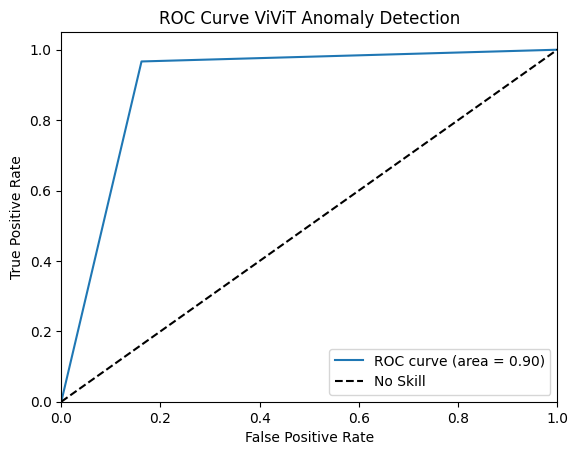

In [16]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ViViT Anomaly Detection')
plt.legend()
plt.show()

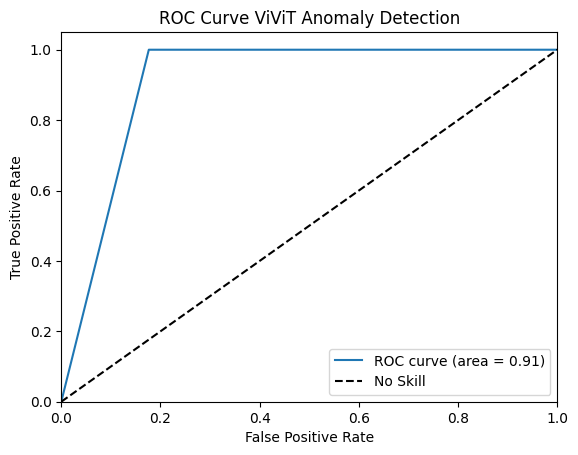

In [46]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ViViT Anomaly Detection')
plt.legend()
plt.show()

In [47]:
roc_auc

np.float64(0.9117647058823529)

In [48]:
from sklearn import metrics

In [60]:
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Anomaly', 'Normal'])


In [62]:
confusion_matrix = np.array([[362, 100],[42,557]])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Anomaly', 'Normal'])


In [65]:
true_pos = np.diag(confusion_matrix)
false_pos = np.sum(confusion_matrix, axis=0) - true_pos
false_neg = np.sum(confusion_matrix, axis=1) - true_pos

precision = np.sum(true_pos / (true_pos + false_pos))
recall = np.sum(true_pos / (true_pos + false_neg))

In [66]:
precision

np.float64(1.7438326024383262)

In [67]:
recall

np.float64(1.7134329221140572)

In [64]:
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

array([0.78354978, 0.92988314])

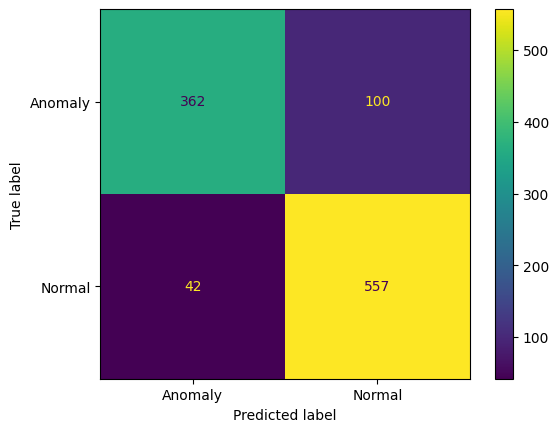

In [63]:
cm_display.plot()
plt.show()

In [57]:
file_name = "C:/Users/rajen/Downloads/leisure-and-people-concept-senior-man-walking-along-summer-city-street_b2bwlw-t__a531337be09c97739d362ec3d9d547d8__P360.mp4"
container = av.open(file_name)

In [59]:
indices = sample_frame_indices(clip_len=10, frame_sample_rate=3,seg_len=container.streams.video[0].frames)
print(f"Processing file {file_name} number of Frames: {container.streams.video[0].frames}")  
video = read_video_pyav(container=container, indices=indices)
inputs = image_processor(list(video), return_tensors="pt")

Processing file C:/Users/rajen/Downloads/leisure-and-people-concept-senior-man-walking-along-summer-city-street_b2bwlw-t__a531337be09c97739d362ec3d9d547d8__P360.mp4 number of Frames: 195


In [60]:

with torch.no_grad():
    outputs = fine_tune_model(**inputs)
    logits = outputs.logits

In [61]:
predicted_label = logits.argmax(-1).item()
prediction = fine_tune_model.config.id2label[predicted_label]
prediction

'Normal'